In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import missingno as msno
from scipy import stats

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix,
    roc_curve, auc, roc_auc_score,
    precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving heart_2020_cleaned.csv to heart_2020_cleaned.csv


In [ ]:
import pandas as pd

data = pd.read_csv("/content/heart_2020_cleaned.csv")

print("Loaded: heart_2020_cleaned.csv")
print("Shape:", data.shape)
data.head()

Loaded: heart_2020_cleaned.csv
Shape: (129711, 18)


,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3,30,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0,0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20,30,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0,0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28,0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


Nulls per column:
 HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    1
GenHealth           1
SleepTime           1
Asthma              1
KidneyDisease       1
SkinCancer          1
dtype: int64


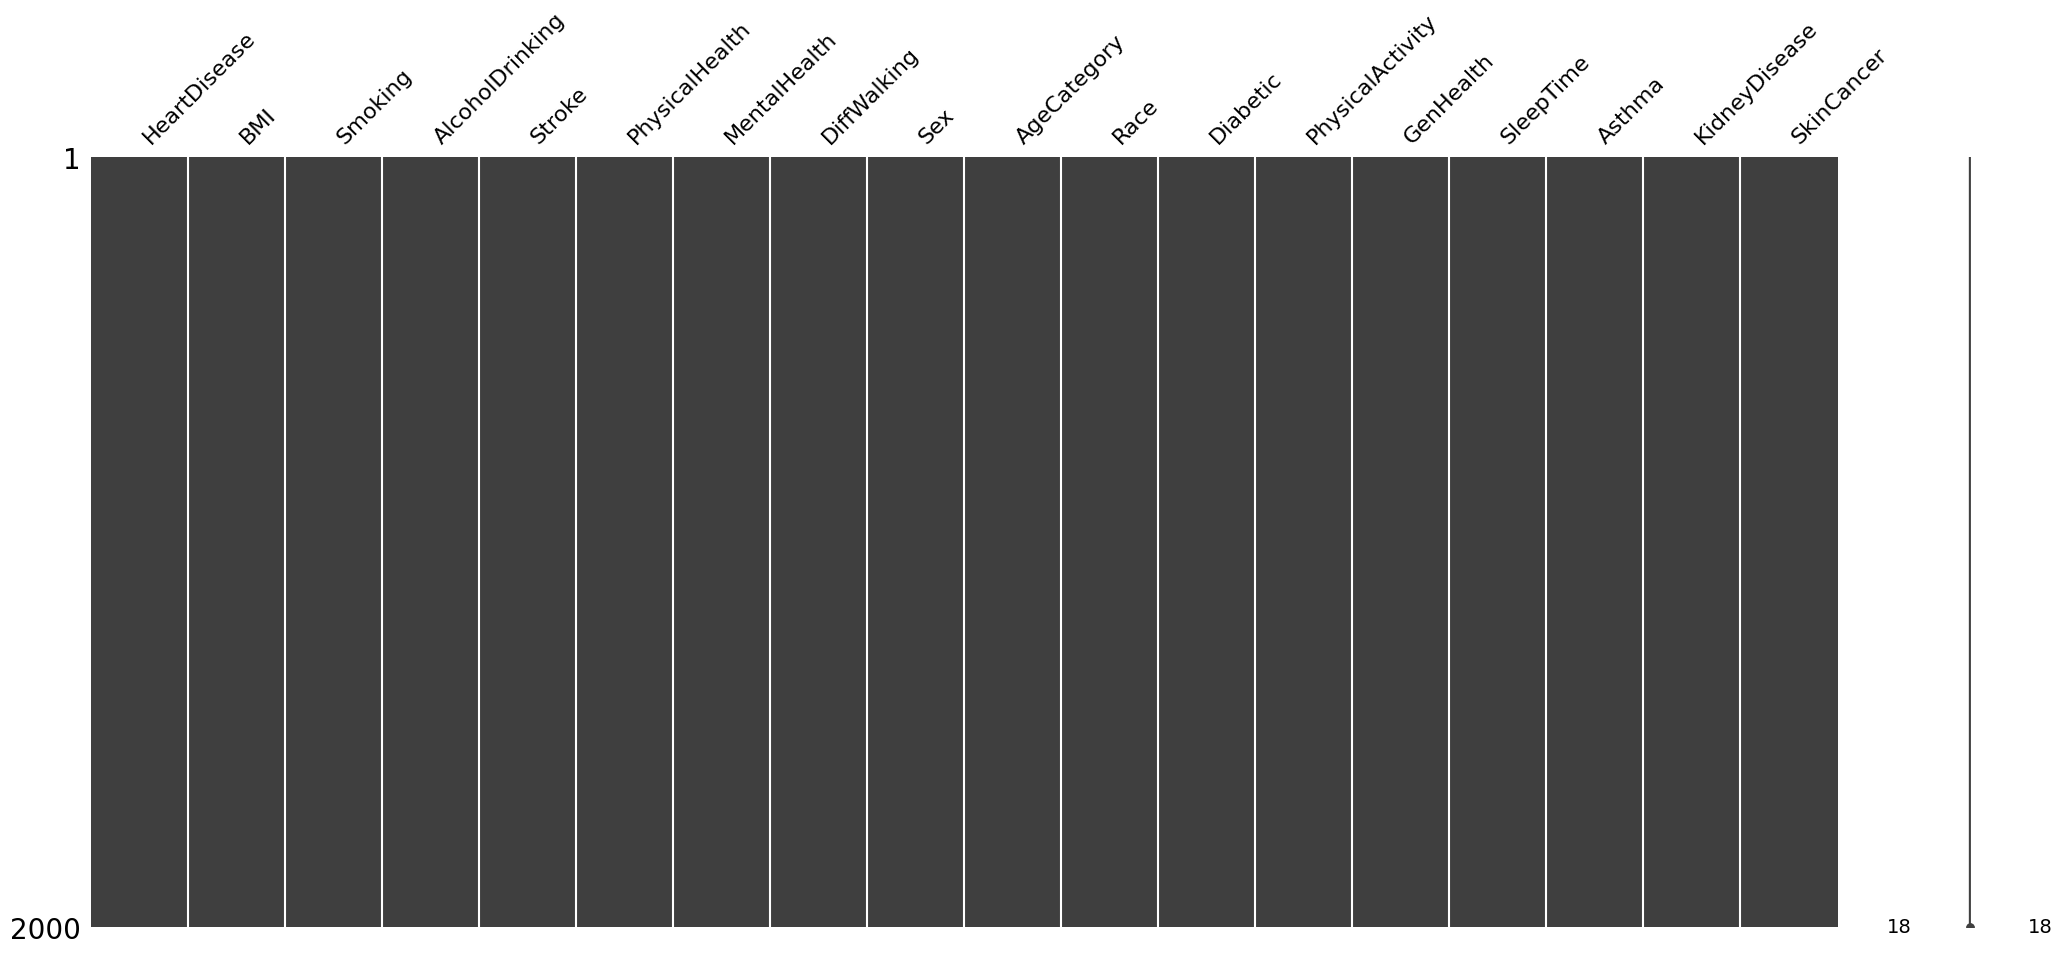

,BMI,PhysicalHealth,MentalHealth,SleepTime
count,129711.000000,129711.000000,129711.000000,129710.000000
mean,28.221057,3.387014,3.914633,7.097402
std,6.365132,7.950910,7.964178,1.464270
min,12.020000,0.000000,0.000000,1.000000
25%,23.800000,0.000000,0.000000,6.000000
50%,27.260000,0.000000,0.000000,7.000000
75%,31.320000,2.000000,3.000000,8.000000
max,94.850000,30.000000,30.000000,24.000000


In [ ]:
print("Nulls per column:\n", data.isnull().sum())

# Visual missingness (even if none, still shows)
msno.matrix(data.sample(2000, random_state=42))
plt.show()

display(data.describe())

In [ ]:
data['HeartDisease'].value_counts()

,count
HeartDisease,
No,118556
Yes,11155


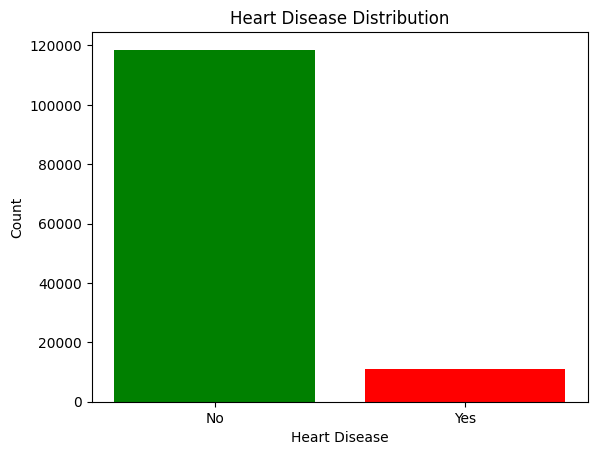

In [ ]:
counts = data['HeartDisease'].value_counts()
labels = ['No', 'Yes']
plt.bar(labels, counts, color=['green', 'red'])
plt.xlabel("Heart Disease")
plt.ylabel("Count")
plt.title("Heart Disease Distribution")
plt.show()

In [ ]:
target_ratio = data['HeartDisease'].value_counts(normalize=True)*100
print("Target %:\n", target_ratio)

Target %:
 HeartDisease
No     91.400113
Yes     8.599887
Name: proportion, dtype: float64


In [ ]:
unique_counts = data.nunique()
print(unique_counts)

HeartDisease           2
BMI                 2972
Smoking                2
AlcoholDrinking        2
Stroke                 2
PhysicalHealth        31
MentalHealth          31
DiffWalking            2
Sex                    2
AgeCategory           13
Race                   6
Diabetic               5
PhysicalActivity       2
GenHealth              5
SleepTime             23
Asthma                 2
KidneyDisease          2
SkinCancer             2
dtype: int64


In [ ]:
target_col = "HeartDisease"
X = data.drop(columns=[target_col])
y = data[target_col].map({"No": 0, "Yes": 1})  # ✅ target clean binary

numeric_features = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
categorical_features = [c for c in X.columns if c not in numeric_features]

print("Numeric:", numeric_features)
print("Categorical:", categorical_features)

Numeric: ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
Categorical: ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer']


In [ ]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(X.shape, x_train.shape, x_test.shape)

(129711, 17) (103768, 17) (25943, 17)


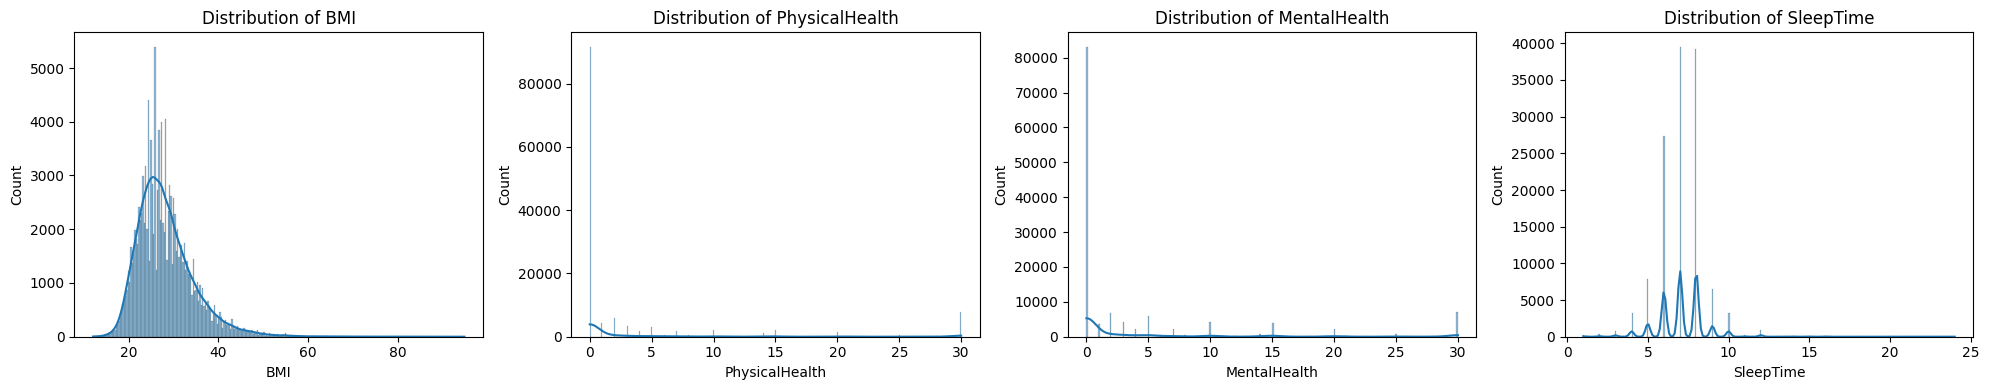

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

for i, col in enumerate(numeric_features):
    sns.histplot(data[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

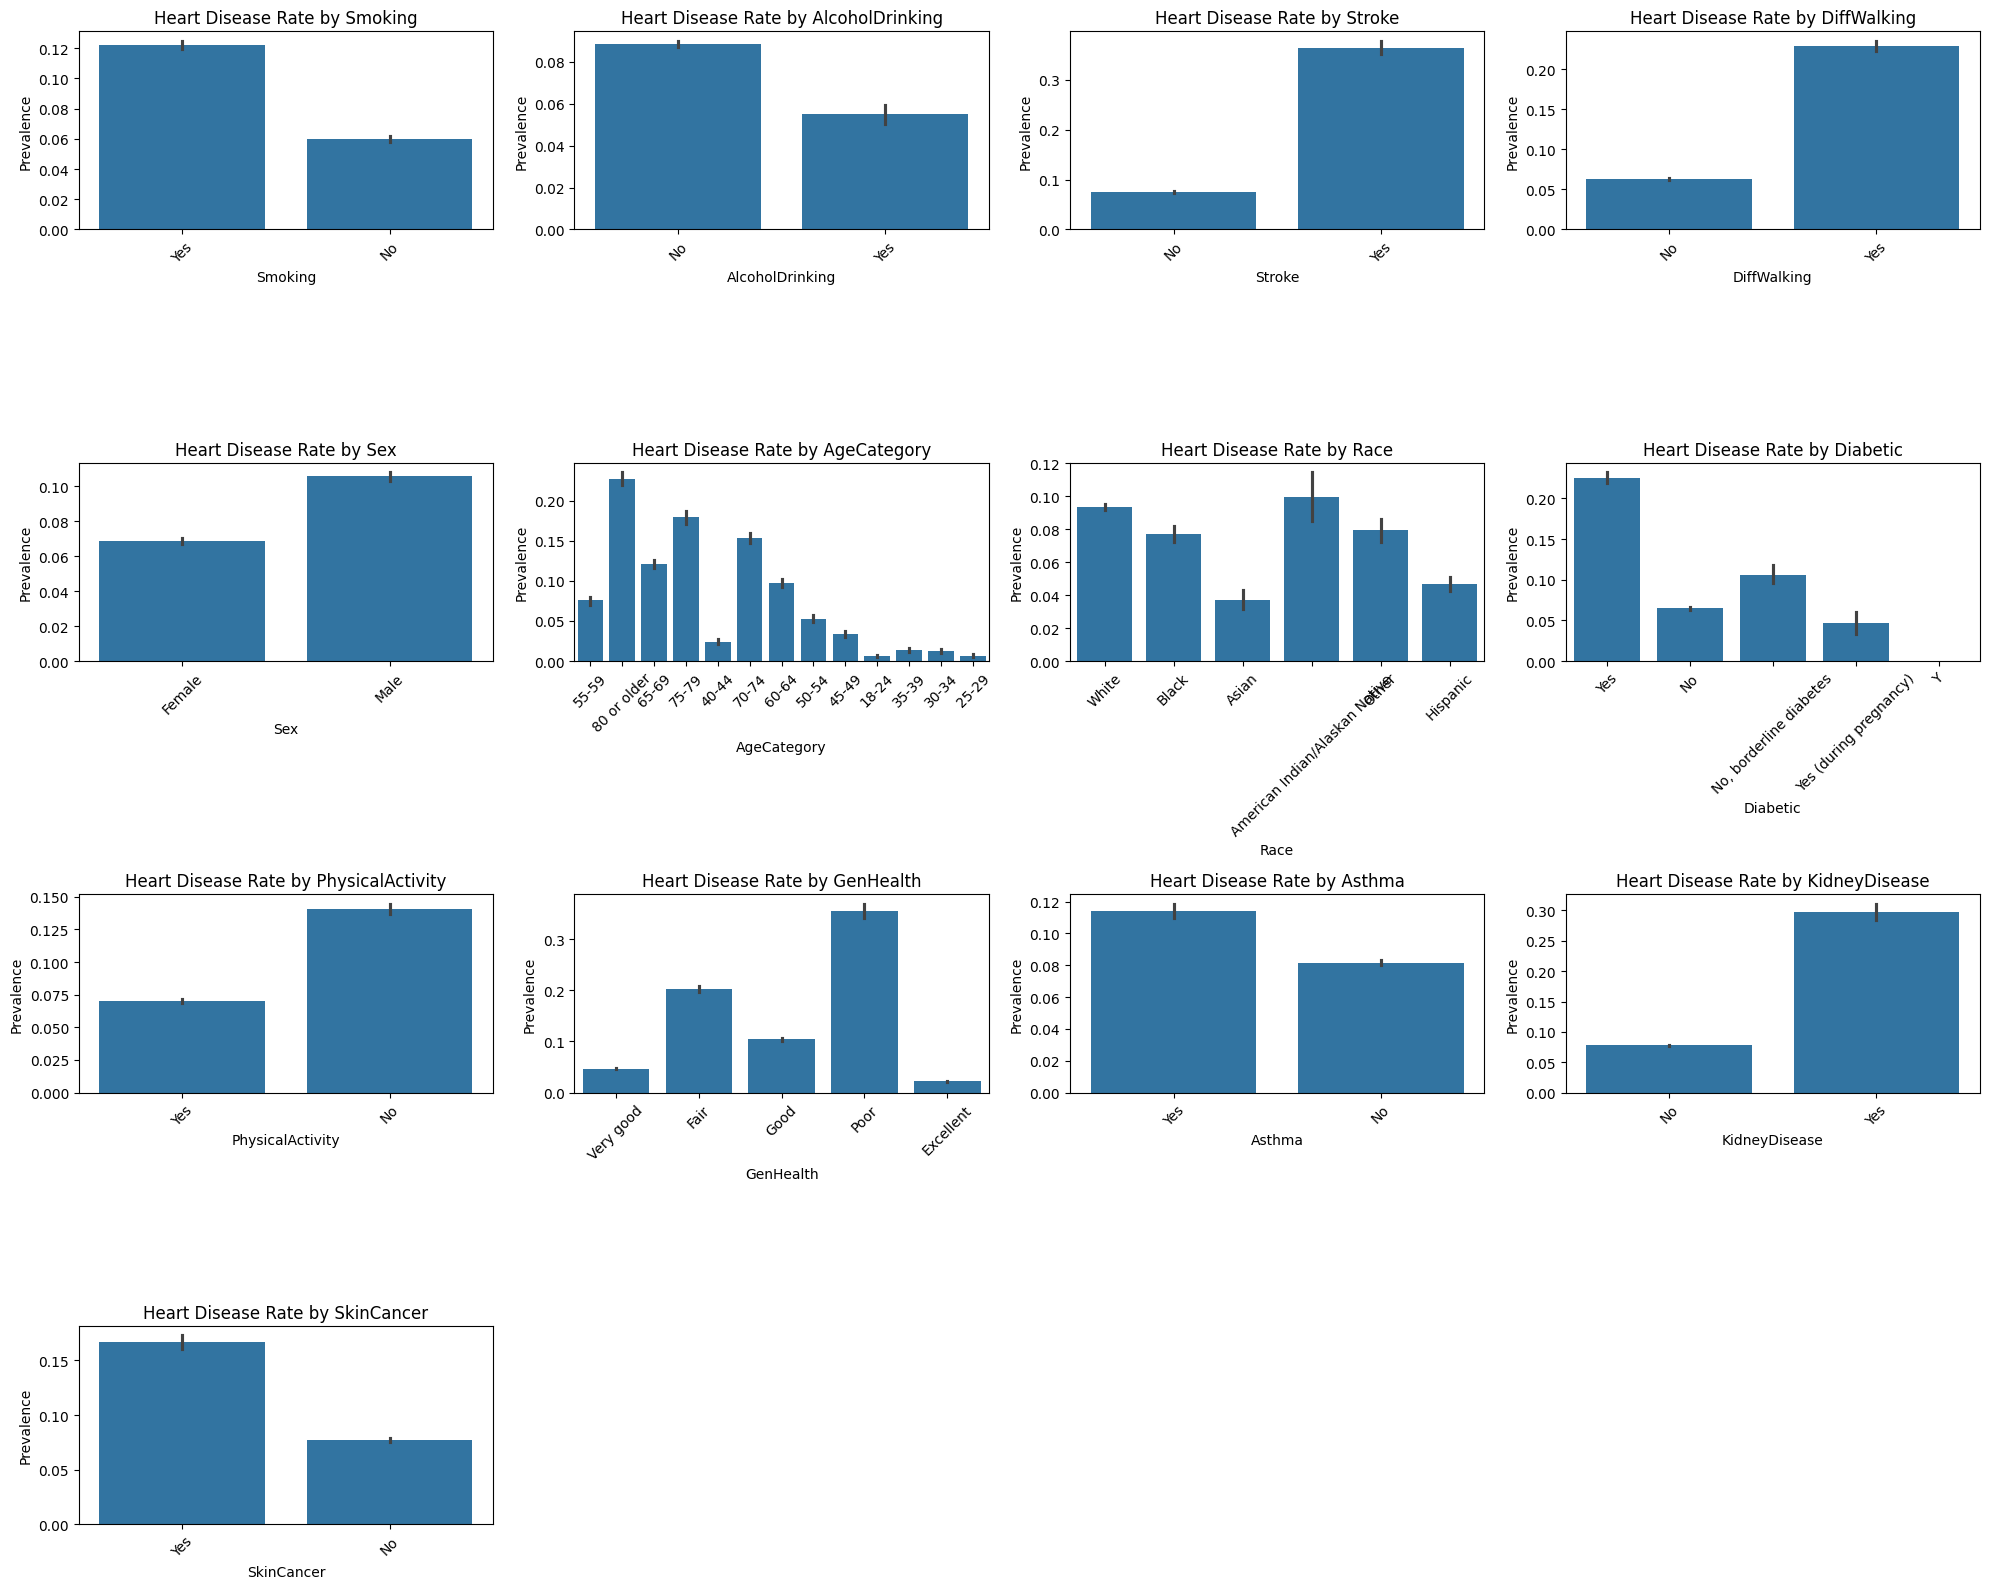

In [ ]:
import math

plot_df = data.copy()
plot_df["HeartDisease_bin"] = plot_df["HeartDisease"].map({"No": 0, "Yes": 1})

cols_per_row = 4
num_features = len(categorical_features)
num_rows = math.ceil(num_features / cols_per_row)

fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(5 * cols_per_row, 4 * num_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    sns.barplot(
        x=col,
        y='HeartDisease_bin',
        data=plot_df,
        estimator=lambda x: sum(x)/len(x),
        ax=axes[i]
    )
    axes[i].set_title(f'Heart Disease Rate by {col}')
    axes[i].set_ylabel('Prevalence')
    axes[i].set_xlabel(col)
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

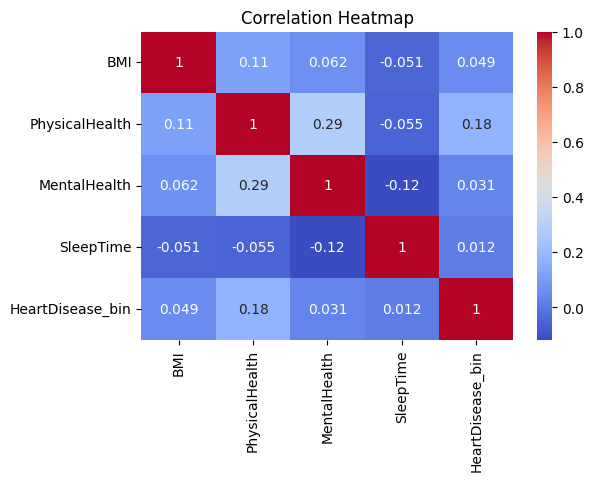

In [ ]:
corr_df = plot_df[numeric_features + ["HeartDisease_bin"]].corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr_df, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
models = [
    ("KNN", KNeighborsClassifier()),
    ("LogReg", LogisticRegression(max_iter=2000, class_weight="balanced")),
    ("RF", RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced"))
]

In [ ]:
results = []

for name, clf in models:
    pipe = Pipeline(steps=[("preprocess", preprocess),
                          ("model", clf)])

    pipe.fit(x_train, y_train)
    y_pred = pipe.predict(x_test)

    # Probabilities (ROC / PR)
    if hasattr(pipe.named_steps["model"], "predict_proba"):
        y_prob = pipe.predict_proba(x_test)[:, 1]
    else:
        y_prob = None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    roc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan
    pr = average_precision_score(y_test, y_prob) if y_prob is not None else np.nan

    results.append([name, acc, prec, rec, f1, roc, pr])

    print(f"Model: {name}")
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1:", f1)
    print("ROC-AUC:", roc)
    print("PR-AUC:", pr)
    print("-"*40)

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1", "ROC_AUC", "PR_AUC"])
display(results_df.sort_values("PR_AUC", ascending=False))

Model: KNN
Accuracy: 0.9072967659869714
Precision: 0.3326923076923077
Recall: 0.07754370237561632
F1: 0.1257724463831334
ROC-AUC: 0.6758700022562699
PR-AUC: 0.16640244386071307
----------------------------------------
Model: LogReg
Accuracy: 0.7515322052191342
Precision: 0.22802942315137437
Recall: 0.7920215150156881
F1: 0.3541082164328657
ROC-AUC: 0.8444361623812661
PR-AUC: 0.3633759778117307
----------------------------------------
Model: RF
Accuracy: 0.9038661681378406
Precision: 0.332484076433121
Recall: 0.11698789780367548
F1: 0.17307692307692307
ROC-AUC: 0.7958761147515895
PR-AUC: 0.2570020169420339
----------------------------------------


,Model,Accuracy,Precision,Recall,F1,ROC_AUC,PR_AUC
1,LogReg,0.751532,0.228029,0.792022,0.354108,0.844436,0.363376
2,RF,0.903866,0.332484,0.116988,0.173077,0.795876,0.257002
0,KNN,0.907297,0.332692,0.077544,0.125772,0.675870,0.166402


================================== MODEL: KNN ==================================

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     23712
           1       0.33      0.08      0.13      2231

    accuracy                           0.91     25943
   macro avg       0.63      0.53      0.54     25943
weighted avg       0.87      0.91      0.88     25943



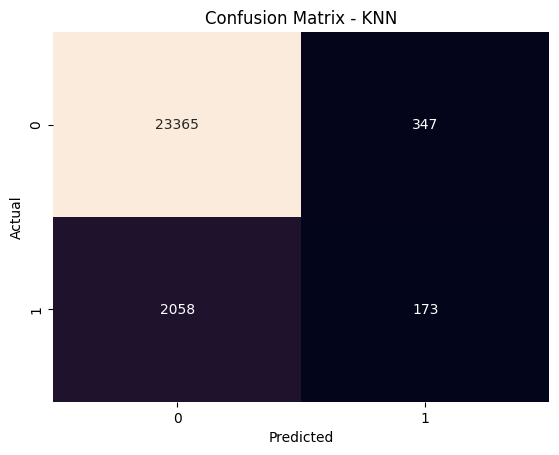

================================ MODEL: LogReg =================================

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

           0       0.97      0.75      0.85     23712
           1       0.23      0.79      0.35      2231

    accuracy                           0.75     25943
   macro avg       0.60      0.77      0.60     25943
weighted avg       0.91      0.75      0.80     25943



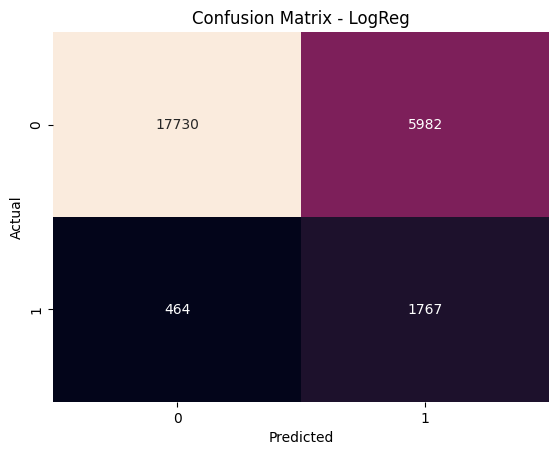

================================== MODEL: RF ===================================

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     23712
           1       0.33      0.12      0.17      2231

    accuracy                           0.90     25943
   macro avg       0.63      0.55      0.56     25943
weighted avg       0.87      0.90      0.88     25943



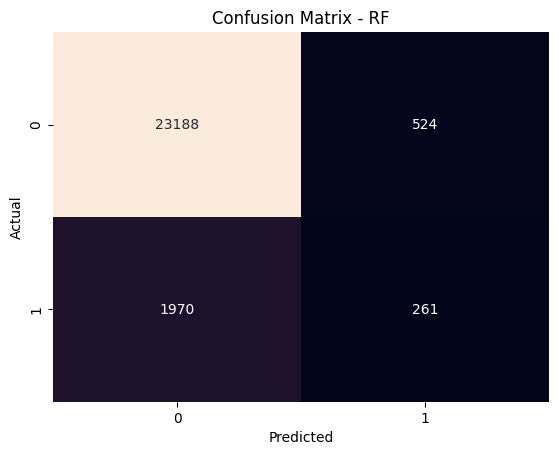

In [ ]:
for name, clf in models:
    print("=" * 80)
    print(f" MODEL: {name} ".center(80, "="))
    print("=" * 80)

    pipe = Pipeline(steps=[("preprocess", preprocess),
                          ("model", clf)])
    pipe.fit(x_train, y_train)
    y_pred = pipe.predict(x_test)

    print("\nCLASSIFICATION REPORT:\n")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cbar=False)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

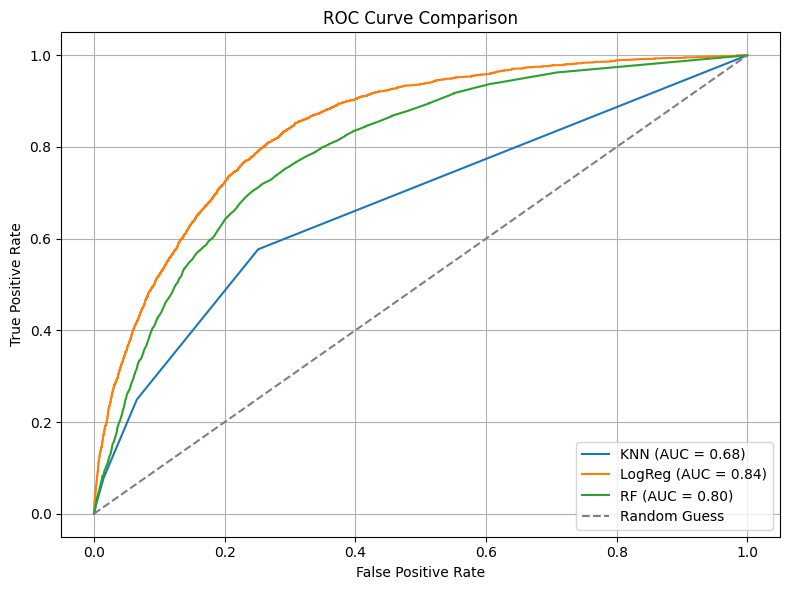

In [ ]:
plt.figure(figsize=(8, 6))

for name, clf in models:
    pipe = Pipeline(steps=[("preprocess", preprocess),
                          ("model", clf)])
    pipe.fit(x_train, y_train)

    if hasattr(pipe.named_steps["model"], "predict_proba"):
        y_score = pipe.predict_proba(x_test)[:, 1]
    else:
        continue

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
best_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

best_pipe.fit(x_train, y_train)
y_prob = best_pipe.predict_proba(x_test)[:, 1]

threshold = 0.35  # try 0.3, 0.35, 0.4
y_pred_thr = (y_prob >= threshold).astype(int)

print("Threshold:", threshold)
print("Precision:", precision_score(y_test, y_pred_thr))
print("Recall:", recall_score(y_test, y_pred_thr))
print("F1:", f1_score(y_test, y_pred_thr))
print("\nReport:\n", classification_report(y_test, y_pred_thr))

Threshold: 0.35
Precision: 0.17800815169236223
Recall: 0.9004930524428507
F1: 0.2972553081305023

Report:
               precision    recall  f1-score   support

           0       0.98      0.61      0.75     23712
           1       0.18      0.90      0.30      2231

    accuracy                           0.63     25943
   macro avg       0.58      0.75      0.52     25943
weighted avg       0.92      0.63      0.71     25943



In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipe_lr = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

scores = cross_validate(
    pipe_lr, X, y,
    scoring=["accuracy", "precision", "recall", "f1", "roc_auc"],
    cv=cv, n_jobs=-1
)

for k, v in scores.items():
    if k.startswith("test_"):
        print(k, "mean:", np.mean(v), "std:", np.std(v))

test_accuracy mean: 0.7524959050363857 std: 0.0036586085156889462
test_precision mean: 0.22722203406999789 std: 0.003619742320002309
test_recall mean: 0.7819811743612729 std: 0.0071973989463627285
test_f1 mean: 0.35211990907438306 std: 0.004968923522421288
test_roc_auc mean: 0.8424853788259977 std: 0.0021668682116540903


In [25]:
param_grid = {
    "model__n_estimators": [150],   # sirf 1 value
    "model__max_depth": [None, 15], # 2 values
}

grid = GridSearchCV(
    pipe_rf,
    param_grid=param_grid,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid.fit(x_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['BMI',
                                                                          'PhysicalHealth',
                                                                          'MentalHealth',
                                                                          'SleepTime']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Smoking',
                                                                          'AlcoholDrinking',
                                                                          'Stroke',
                                                                          'DiffWalking',
                                                                          'Sex',
                                                                          'AgeCategory',
                                                                          'Race',
                                                                          'Diabetic',
                                                                          'PhysicalActivity',
                                                                          'GenHealth',
                                                                          'Asthma',
                                                                          'KidneyDisease',
                                                                          'SkinCancer'])])),
                                       ('model',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 15],
                         'model__n_estimators': [150]},
             scoring='f1', verbose=1)

Best Parameters: {'model__max_depth': 15, 'model__n_estimators': 150}

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.83      0.89     23712
           1       0.26      0.64      0.37      2231

    accuracy                           0.81     25943
   macro avg       0.61      0.73      0.63     25943
weighted avg       0.90      0.81      0.84     25943



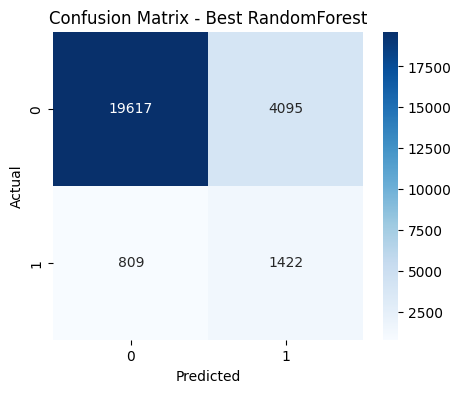

In [26]:
best_rf = grid.best_estimator_

y_pred = best_rf.predict(x_test)

print("Best Parameters:", grid.best_params_)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Best RandomForest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()